Extract generic statistics and information about a given dataset.

- - -


# Imports

In [1]:
import sys

In [2]:
sys.path.append("../config/")
import config

## General

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [4]:
from IPython.display import display, HTML

In [5]:
import pyspark.sql.functions as fn
import pyspark.sql.types as t

# Load from Parquet

In [6]:
keyruneCode = "M20"

In [7]:
df = spark.read.parquet(f'{config.OUTPUT_DATASET}/{keyruneCode}_cards.parquet')

# Descriptive Statistics 

## Total number of cards 

In [8]:
print(f'Total cards int the set: {df.count()}')

Total cards int the set: 329


In [9]:
print(f'Total cards int the set: {df.distinct().count()}')

Total cards int the set: 329


## Types

In [10]:
df_result = df.select(fn.col('types').alias('Permanent Type')).distinct()
pd_df = df_result.toPandas()

In [11]:
pd_df

,Permanent Type
0,Land
1,Sorcery
2,Instant
3,Enchantment
4,Artifact
5,"Artifact,Creature"
6,Planeswalker
7,Creature


In [12]:
card_sum = df.groupBy("types").count().agg(
    fn.sum("count")
)

In [13]:
card_sum = int(card_sum.toPandas().loc[0])

In [14]:
df_result = df.groupBy(fn.col('types').alias('Parmanent Type')).count()
pd_df = df_result.toPandas()

In [15]:
pd_df

,Parmanent Type,count
0,Land,24
1,Sorcery,27
2,Instant,37
3,Enchantment,21
4,Artifact,17
5,"Artifact,Creature",10
6,Planeswalker,12
7,Creature,181


In [16]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_perma_types.md", "w") as fp:
    pd_df.to_markdown(fp)

In [17]:
bcast = sc.broadcast(card_sum)

@fn.udf(returnType=t.FloatType())
def udf_count_to_perc(count):
#     print(count, bcast.value)
    return count / bcast.value

In [18]:
df_result = df.groupBy(fn.col("types").alias('Permanent Type')).count().withColumn('perc', fn.format_number(udf_count_to_perc('count'), 2))
pd_df = df_result.toPandas()

In [19]:
pd_df

,Permanent Type,count,perc
0,Land,24,0.07
1,Sorcery,27,0.08
2,Instant,37,0.11
3,Enchantment,21,0.06
4,Artifact,17,0.05
5,"Artifact,Creature",10,0.03
6,Planeswalker,12,0.04
7,Creature,181,0.55


In [20]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_perma_types_stats.md", "w") as fp:
    pd_df.to_markdown(fp)

In [21]:
df_result = df.groupBy("encodedTypes").count()
pd_df = df_result.toPandas()

In [22]:
pd_df

,encodedTypes,count
0,1,10
1,6,12
2,3,21
3,5,24
4,4,37
5,7,27
6,2,181
7,0,17


## Power & Toughness

In [23]:
df_result = df.select("name", "power", "toughness").where("encodedTypes == 2")
df_result = df_result.na.fill(0)
pd_df = df_result.toPandas()

In [24]:
pd_df

,name,power,toughness
0,Cavalier of Flame,6,5
1,Cavalier of Thorns,5,6
2,"Omnath, Locus of the Roil",3,3
3,"Kaalia, Zenith Seeker",3,3
4,Coral Merfolk,2,1
...,...,...,...
176,Concordia Pegasus,1,3
177,Phantom Warrior,2,2
178,Imperial Outrider,1,5
179,Vorstclaw,7,7


In [25]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_creatures_power_toughness.md", "w") as fp:
    pd_df.to_markdown(fp)

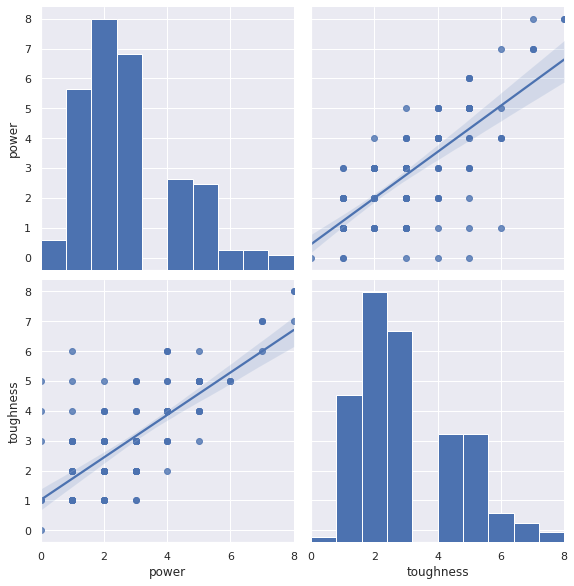

In [26]:
ax = sns.pairplot(pd_df, height=4, kind='reg')

In [27]:
ax.savefig(f"{config.ARTIFACTS}/EDA/{keyruneCode}_power_toughness_pairplot.png")

In [28]:
# df_result.corr("power", "toughness", method="pearson")

In [29]:
pd_df.corr(method="spearman")

,power,toughness
power,1.000000,0.656139
toughness,0.656139,1.000000


In [30]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_creatures_power_toughness_correlation_spearman.md", "w") as fp:
    pd_df.to_markdown(fp)

In [31]:
df.agg({"toughness": "mean"}).collect()

[Row(avg(toughness)=2.93717277486911)]

In [32]:
df_result = df.agg(
    *[fn.min("power").alias("min"),
      fn.max("power").alias("max"),
      fn.format_number(fn.mean("power"), 2).alias("avg")
])
pd_df_power = df_result.toPandas().rename(index={0: 'power'})

In [33]:
df_result = df.agg(
    *[fn.min("toughness").alias("min"),
      fn.max("toughness").alias("max"),
      fn.format_number(fn.mean("toughness"), 2).alias("avg")
])
pd_df_toughness = df_result.toPandas().rename(index={0: 'toughness'})

In [34]:
pd.concat([pd_df_power, pd_df_toughness])

,min,max,avg
power,0,8,2.74
toughness,0,8,2.94


In [35]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_creatures_power_toughness_agg_min_max_avg.md", "w") as fp:
    pd_df.to_markdown(fp)

## Length of name 

In [36]:
df_result = df.selectExpr("name").select('name', fn.length("name").alias("length"))
pd_df = df_result.toPandas()

In [37]:
pd_df

,name,length
0,"Chandra, Awakened Inferno",25
1,Cavalier of Flame,17
2,Cavalier of Thorns,18
3,"Omnath, Locus of the Roil",25
4,Mask of Immolation,18
...,...,...
324,Concordia Pegasus,17
325,Phantom Warrior,15
326,Imperial Outrider,17
327,Vorstclaw,9


In [38]:
df_result = df.selectExpr("name").\
    select("name", fn.split("name", "\s+").alias("tokens")).\
    select("name", "tokens", fn.size("tokens").alias("# tokens"))
pd_df = df_result.toPandas()

In [39]:
pd_df

,name,tokens,# tokens
0,"Chandra, Awakened Inferno","[Chandra,, Awakened, Inferno]",3
1,Cavalier of Flame,"[Cavalier, of, Flame]",3
2,Cavalier of Thorns,"[Cavalier, of, Thorns]",3
3,"Omnath, Locus of the Roil","[Omnath,, Locus, of, the, Roil]",5
4,Mask of Immolation,"[Mask, of, Immolation]",3
...,...,...,...
324,Concordia Pegasus,"[Concordia, Pegasus]",2
325,Phantom Warrior,"[Phantom, Warrior]",2
326,Imperial Outrider,"[Imperial, Outrider]",2
327,Vorstclaw,[Vorstclaw],1


In [40]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_cards_names_length_and_tokens.md", "w") as fp:
    pd_df.to_markdown(fp)

## Length of text 

In [41]:
df_result = df.selectExpr("name", "originalText").\
    select(fn.col("name").alias("card name"), fn.length("originalText").alias("length")).\
    orderBy(fn.desc("length"))
df_result = df_result.na.fill(value=0, subset=['length'])
pd_df = df_result.toPandas()

In [42]:
pd_df

,card name,length
0,"Ajani, Strength of the Pride",419
1,"Chandra, Awakened Inferno",378
2,"Chandra, Acolyte of Flame",368
3,"Sorin, Imperious Bloodlord",332
4,Cavalier of Flame,331
...,...,...
324,Fearless Halberdier,0
325,Prowling Caracal,0
326,Imperial Outrider,0
327,Vorstclaw,0


In [43]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_cards_text_length.md", "w") as fp:
    pd_df.to_markdown(fp)

## Mana costs 

In [44]:
df_result = df.select(fn.col("name").alias("card name"),
                      fn.col("convertedManaCost").alias("converted mana cost")).\
                orderBy(fn.desc("converted mana cost"))
pd_df = df_result.toPandas()

In [45]:
pd_df

,card name,converted mana cost
0,"Vilis, Broker of Blood",8
1,"Sephara, Sky's Blade",7
2,"Drakuseth, Maw of Flames",7
3,Meteor Golem,7
4,Scholar of the Ages,7
...,...,...
324,Tranquil Cove,0
325,Temple of Silence,0
326,Bloodfell Caves,0
327,Island,0


In [46]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_cards_cmc.md", "w") as fp:
    pd_df.to_markdown(fp)

In [47]:
max_cmc = pd_df['converted mana cost'].max()

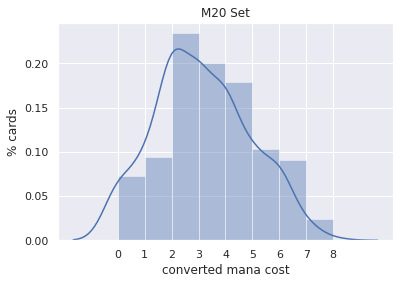

In [48]:
ax = sns.distplot(pd_df['converted mana cost'], bins=range(max_cmc + 1))
_ = ax.set_ylabel('% cards')
_ = ax.set_title(f'{keyruneCode} Set')
_ = ax.set_xticks(range(max_cmc + 1))

In [49]:
ax.figure.savefig(f"{config.ARTIFACTS}/EDA/{keyruneCode}_cards_cmc_plot.png")

# Groups 

## By color identity

In [50]:
df_result = df.groupby(fn.col('colorIdentity').alias('Color Identity')).count()
pd_df = df_result.toPandas()

In [51]:
pd_df

,Color Identity,count
0,"G,W",2
1,"G,R,U",1
2,"B,G,U",1
3,"B,G,W",1
4,"B,G,R,U,W",1
5,B,55
6,"R,W",3
7,"G,R,W",1
8,"G,R",2
9,U,50


In [52]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_cards_cmc_groups_count.md", "w") as fp:
    pd_df.to_markdown(fp)

In [53]:
df_result = df.groupby('colorIdentity').count().agg(
    fn.sum("count").alias("total number")
).collect()

In [54]:
print(df_result)

[Row(total number=329)]


## From Models, show encoded types

In [55]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel

In [56]:
indexer = StringIndexer.load(f"{config.SPARK_MODELS}/{keyruneCode}/stringindexer_str_types")
model = StringIndexerModel.load(f"{config.SPARK_MODELS}/{keyruneCode}/stringindexer_model_str_types")

In [57]:
# model.stringOrderType

In [58]:
model.labels

['Artifact',
 'Artifact,Creature',
 'Creature',
 'Enchantment',
 'Instant',
 'Land',
 'Planeswalker',
 'Sorcery']

In [59]:
df.agg(
    *[fn.min(df.encodedTypes), fn.max(df.encodedTypes)]
).show()

+-----------------+-----------------+
|min(encodedTypes)|max(encodedTypes)|
+-----------------+-----------------+
|                0|                7|
+-----------------+-----------------+



## Make an overall histogram from encoded types. 

In [60]:
tmp = df.select("encodedTypes").rdd.flatMap(lambda x: x)

In [61]:
tmp.min(), tmp.max()

(0, 7)

In [62]:
hist = df.select("encodedTypes").rdd.flatMap(lambda x: x).histogram(8)

In [63]:
hist

([0.0, 0.875, 1.75, 2.625, 3.5, 4.375, 5.25, 6.125, 7],
 [17, 10, 181, 21, 37, 24, 12, 27])

In [64]:
pd_hist = pd.DataFrame(data=list(zip(*hist)), columns=['bin', 'freq'])

In [65]:
pd_hist['perc'] = pd_hist['freq'] / pd_hist['freq'].sum()

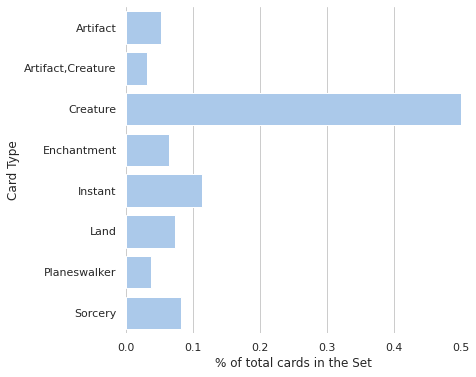

In [66]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="perc", y="bin", data=pd_hist, label="Total", orient='h', color="b")

# ax.set(xlim=(0, 0.4), xlabel="", ylabel="")
ax.set(xlim=(0, 0.5), xlabel="% of total cards in the Set", ylabel="Card Type")
ax.set(yticklabels=model.labels)

sns.despine(left=True, bottom=True)

In [67]:
ax.figure.savefig(f'{config.ARTIFACTS}/EDA/{keyruneCode}_cards_types_hist.png')

## By color identity and encoded type

First, let's fetch the distinct color identities

In [68]:
pd_colorIdentities  = df.select("colorIdentity").alias("Color_Identity").distinct().sort("colorIdentity").toPandas()

In [69]:
pd_colorIdentities

,colorIdentity
0,
1,B
2,"B,G"
3,"B,G,R,U,W"
4,"B,G,U"
5,"B,G,W"
6,"B,R"
7,"B,R,W"
8,"B,U"
9,"B,W"


In [70]:
pd_encodedTypes = pd.DataFrame(np.arange(8), columns=['Encoded_Types'])

In [71]:
pd_encodedTypes

,Encoded_Types
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


Create a cartesian product of the color identities and the encoded types.

In [72]:
pd_colorIdentities['key'] = 0
pd_encodedTypes['key'] = 0

In [73]:
pd_cartesian = pd_colorIdentities.merge(pd_encodedTypes, how='outer').drop(columns=['key'])

In [74]:
pd_cartesian = pd_cartesian.rename(columns={'colorIdentity':'Color_Identity'})

In [75]:
pd_cartesian

,Color_Identity,Encoded_Types
0,,0
1,,1
2,,2
3,,3
4,,4
...,...,...
179,W,3
180,W,4
181,W,5
182,W,6


Now, let's create a list which will hold the following: ((color identity, encoded type), 1).

In [76]:
map1 = df.select(["colorIdentity", "encodedTypes"]).rdd.map(
    lambda x: ((x[0], x[1]), 1)
)

map1.take(10)

[(('R', 6), 1),
 (('R', 2), 1),
 (('G', 2), 1),
 (('G,R,U', 2), 1),
 (('R', 0), 1),
 (('B,R,W', 2), 1),
 (('U', 2), 1),
 (('W', 2), 1),
 (('G', 0), 1),
 (('G,U', 2), 1)]

Finally, let's compute the sum of the number of a found encoded types per color identity.

In [77]:
map2 = map1.reduceByKey(lambda a, b: a + b).sortByKey()

In [78]:
map2.take(5)

[(('', 0), 11), (('', 1), 9), (('', 5), 4), (('B', 0), 1), (('B', 2), 33)]

For convience, let's break down the (color identity, encoded type) key into a list of: (color identity, encoded type, sum). 

In [79]:
map3 = map2.map(lambda x: (x[0][0], x[0][1], x[1]))

In [80]:
pd_tab = map3.toDF().toPandas()

In [81]:
pd_tab.columns = ['Color_Identity', 'Encoded_Types', 'Total']

In [82]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total
0,,0,11
1,,1,9
2,,5,4
3,B,0,1
4,B,2,33


In [83]:
with open(f"{config.ARTIFACTS}/EDA/{keyruneCode}_cards_ci_type_counts.md", "w") as fp:
    pd_df.to_markdown(fp)

Based on the color identity and encoded types, assign a key that corresponds to the cartesian product.

In [84]:
def assign_index(row):
    filter1 = pd_cartesian['Color_Identity'] ==  row['Color_Identity']
    filter2 = pd_cartesian['Encoded_Types'] == row['Encoded_Types']
    
    idx = pd_cartesian.index[filter1 & filter2].tolist()[0]

    return idx

In [85]:
pd_tab['Cart_Index'] = pd_tab.apply (lambda row: assign_index(row), axis=1)

In [86]:
# pd_tab.max()

In [87]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total,Cart_Index
0,,0,11,0
1,,1,9,1
2,,5,4,5
3,B,0,1,8
4,B,2,33,10


Find the missing indexes from the cartesian product, and fill-in with "total = 0".

In [88]:
missing_cart_indexes = set(pd_cartesian.index.tolist()) - set(pd_tab.Cart_Index.tolist())

In [89]:
for index in missing_cart_indexes:
    row = pd_cartesian.iloc[index]

    new_df = row.copy()
    new_df['Total'] = 0
    new_df['Cart_Index'] = index
    
    pd_tab = pd_tab.append(new_df)

In [90]:
group_result = pd_tab.groupby('Encoded_Types')

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


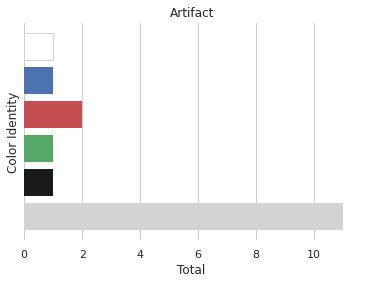

In [91]:
for group_id, (name, indices) in enumerate(group_result.indices.items()):
    group = pd_tab.iloc[indices]
    group.fillna(0)
    
#     print(group)

    f_group = group[group['Total'] > 0]

    labels = f_group['Color_Identity']
    totals = f_group['Total']

    sns.set(style="whitegrid")
    # sns.set()
    sns.set_palette("pastel")

    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        plt.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")

    plt.title(model.labels[group_id])
    plt.xlabel('Total')  
    plt.ylabel('Color Identity')
#     plt.yticks(range(6), labels)
    plt.yticks([])
    sns.despine(left=True, bottom=True)

    plt.show()  
    
    break

### Bars with Gradients

In [92]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

def gradientbars(bars, color):
    grad = np.atleast_2d(np.linspace(0,1,256))
    rgb0 = matplotlib.colors.to_rgba('w')
    rgb1 = matplotlib.colors.to_rgba(color)
    cmap = LinearSegmentedColormap.from_list('tmp', (rgb0, rgb1))

    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x, x+w, y, y+h], cmap=cmap,aspect="auto", zorder=0)

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


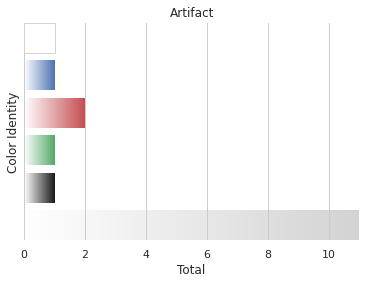

In [93]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set_palette("pastel")


with sns.color_palette("pastel"):
    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    fig, ax = plt.subplots()

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        bar = ax.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")
        
        gradientbars(bar, color)

    ax.set_title(model.labels[group_id])
    ax.set_xlabel('Total')  
    ax.set_ylabel('Color Identity')
    #     plt.yticks(range(6), labels)
    ax.set_yticks([])
    ax.axis('auto')
    sns.despine(left=True, bottom=True)

    plt.show()  

In [94]:
ax.figure.savefig(f'{config.ARTIFACTS}/EDA/{keyruneCode}_cards_artifacts_hist_fx1.png')

### Bars with Gradient and Symbols

In [95]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [96]:
sns.set()

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


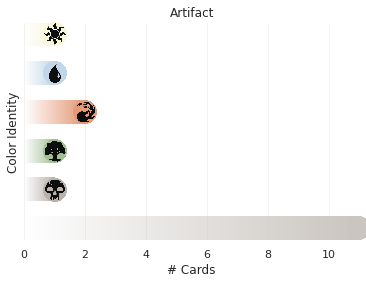

In [97]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set(style="whitegrid")
# sns.set()
sns.set_palette("pastel")

colors = {
    '': '#cac5c0ff',
    'W': '#f8f6d8ff',
    'U': '#c1d7e9ff',
    'B': '#bab1abff',
    'R': '#e49977ff',
    'G': '#a3c095ff'
}

edge_colors = {
    '': '',
    'W': '',
    'U': '',
    'B': '',
    'R': '',
    'G': ''
}

images = {
    '': '../assets/Mana/C.png',
    'W': '../assets/Mana/W.png',
    'U': '../assets/Mana/U.png',
    'B': '../assets/Mana/B.png',
    'R': '../assets/Mana/R.png',
    'G': '../assets/Mana/G.png'
}

fig, ax = plt.subplots()

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    color = colors[label]
    ecolor = ''
    image = images[label]
    bar = plt.barh(i, val, color=color, height=0.60, linewidth=0.0, alpha=1.0, edgecolor=ecolor)#, hatch='/')
    
    ab = AnnotationBbox(OffsetImage(plt.imread(image), zoom=0.075), (val, i), frameon=False)
    ax.add_artist(ab)
    
    gradientbars(bar, color)

plt.title(model.labels[group_id])
plt.xlabel('# Cards')  
plt.ylabel('Color Identity')
plt.yticks([])
plt.grid(linewidth=1.0, alpha=0.25)
sns.despine(left=True, bottom=True)
plt.axis('auto')

plt.show()  

In [98]:
ax.figure.savefig(f'{config.ARTIFACTS}/EDA/{keyruneCode}_cards_artifacts_hist_fx2.png')

<!-- ###  Cummulative Bar -->

In [99]:
# sns.set(style="whitegrid")

# prev = 0 
# for i in range(len(totals)):
#     val = totals.iloc[i]
#     label = labels.iloc[i]
    
#     plt.barh(i, val)
# #     prev = prev + val

# plt.xlabel('Total')  
# plt.ylabel('Spell Type')

# plt.show()  